# Prepare Google Colab Environment

In [1]:
#for colab users - highly recommended!!!
from google.colab import drive
#update your path variable + in line 5 spereatly!!!!
path = ...
drive.mount('/content/drive/')
%cd ...#write the path value here as well
%ls
#you should see printed by the %ls line the items in you directory- .ipynb file, images/, STEGO/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/project/project_stegoV3/project_stegoV3
Copy_of_STEGO_Colab_V3.ipynb  project_stego_final_idea_testing.ipynb  STEGO/
images/                       project_stego_final.ipynb


In [2]:
#all required installation. note that if its not your first time running this script you might need
#to restart the session and rerun this file
!pip install wget
!pip install torchmetrics
!pip install hydra-core
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git
!pip install omegaconf
!pip install pytorch-lightning


  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-ox25y73l
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-ox25y73l
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 2723c7fa4f2ead16ae1ce3d8afe977724bb8f87f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0-cp310-cp310-linux_x86_64.whl size=3405184 sha256=c31a60020f730d77fd5a7080b00af1aa19ddd7d5746080c772e2a30efac6b855
  Stored in directory: /tmp/pip-ephem-wheel-cache-nf7muzm3/wheels/01/5b/61/87443ed3bf03dd2940375cf2f8b6fba88efece935465e490b0
Successfully built pydensecrf
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 4.2 MB/s eta 0:00:00


In [3]:
#important! this defines the resolution at which we are working with
resolution_def = 112*6

# Download Pretrained Model



In [4]:
#downloading the latest pre-trained model
import os
from os.path import join
os.chdir("STEGO/src")
saved_models_dir = join("..", "saved_models")
os.makedirs(saved_models_dir, exist_ok=True)

In [5]:
#updating the saved model
import wget
saved_model_url_root = "https://marhamilresearch4.blob.core.windows.net/stego-public/saved_models/"
saved_model_name = "cocostuff27_vit_base_5.ckpt"
if not os.path.exists(join(saved_models_dir, saved_model_name)):
  wget.download(saved_model_url_root + saved_model_name, join(saved_models_dir, saved_model_name))

# Load pretrained STEGO

In [6]:
#loading the model
from train_segmentation import LitUnsupervisedSegmenter
model = LitUnsupervisedSegmenter.load_from_checkpoint(join(saved_models_dir, saved_model_name)).cuda()
print(type(model))

/content/drive/MyDrive/project/project_stegoV3/project_stegoV3/STEGO/src/train_segmentation.py:386: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="configs", config_name="train_config.yml")
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/migration/migration.py:208: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.4.5 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../saved_mo

Since no pretrained weights have been provided, we load the reference pretrained DINO weights.


Downloading: "https://dl.fbaipublicfiles.com/dino/dino_vitbase8_pretrain/dino_vitbase8_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_vitbase8_pretrain.pth
100%|██████████| 327M/327M [00:07<00:00, 47.6MB/s]


<class 'train_segmentation.LitUnsupervisedSegmenter'>


# Query model and pass result through CRF

In [7]:
#an example of how to use the STEGO model
import torch.nn.functional as F
from crf import dense_crf
import torch
from PIL import Image
import requests
from io import BytesIO
from torchvision.transforms.functional import to_tensor
from utils import get_transform


img = Image.open(path+'images/tv_stand.jpg')
transform = get_transform(448, False, "center")
img = transform(img).unsqueeze(0).cuda()

with torch.no_grad():
  code1 = model(img)
  code2 = model(img.flip(dims=[3]))
  code  = (code1 + code2.flip(dims=[3])) / 2
  code = F.interpolate(code, img.shape[-2:], mode='bilinear', align_corners=False)
  linear_probs = torch.log_softmax(model.linear_probe(code), dim=1).cpu()
  cluster_probs = model.cluster_probe(code, 2, log_probs=True).cpu()

  single_img = img[0].cpu()
  linear_pred = dense_crf(single_img, linear_probs[0]).argmax(0)
  cluster_pred = dense_crf(single_img, cluster_probs[0]).argmax(0)

**define the segmentation activation function**


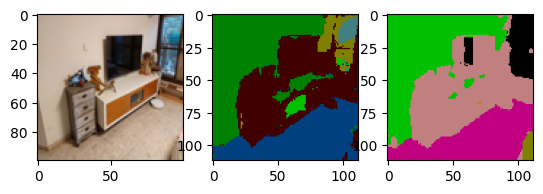

In [8]:
#This is the function we use to pass images through the model
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
from utils import unnorm, remove_axes
import numpy as np
def segmentation(img,resolution=112,clustflag=True,linflag=True):
    img2 = img
    transform = get_transform(resolution, False, "center")
    img = transform(img).unsqueeze(0).cuda()
    linear_probs=0
    cluster_probs=0
    img_cluster_pred=0
    img_linear_pred=0
    with torch.no_grad():
      code1 = model(img)
      code2 = model(img.flip(dims=[3]))
      code  = (code1 + code2.flip(dims=[3])) / 2
      code = F.interpolate(code, img.shape[-2:], mode='bilinear', align_corners=False)
      if linflag:
        linear_probs = torch.log_softmax(model.linear_probe(code), dim=1).cpu()
      if clustflag:
        cluster_probs = model.cluster_probe(code, 2, log_probs=True).cpu()

      single_img = img[0].cpu()
      if linflag:
        linear_pred = dense_crf(single_img, linear_probs[0]).argmax(0)
      if clustflag:
        cluster_pred = dense_crf(single_img, cluster_probs[0]).argmax(0)
    if clustflag:
        img_cluster_pred = model.label_cmap[cluster_pred]
        img_cluster_pred=Image.fromarray(img_cluster_pred.astype(np.uint8))
    if linflag:
        img_linear_pred = model.label_cmap[linear_pred]
        img_linear_pred=Image.fromarray(img_linear_pred.astype(np.uint8))
    return img2, img_cluster_pred, img_linear_pred

#example on how to use our function
address = path + 'images/tv_stand.jpg'
img = Image.open(address).resize((100,100))

img, img_cluster_pred, img_linear_pred = segmentation(img)#activation example
plt.subplot(1,3,1)
plt.imshow(img)
plt.subplot(1,3,2)
plt.imshow(img_cluster_pred)
plt.subplot(1,3,3)
plt.imshow(img_linear_pred)

**define help functions, and a function to extarct a patch of an image based on entropy**

In [9]:
import numpy as np
from skimage.filters.rank import entropy
from skimage.morphology import disk
import numpy as np
import cv2

#a help function to transfor RGB to grayscale
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

#MSE function between two same sized matrix/images
def mse(patch1, patch2):
    return np.mean((patch1 - patch2) ** 2)

#a function to find a patch in the middle region of the image based on highest greyscale entropy
#this function returns both the patch itself and the location of it in the original image
def patch_new(img,patch_size=50):
  if img.ndim == 3:
    img2 = rgb2gray(img)/255
  M,N = img2[:,:].shape
  small_img = img2[M//4:3*M//4,N//4:3*N//4]
  entropies = entropy(small_img, disk(patch_size))
  max_entropy_position = np.unravel_index(np.argmax(entropies), entropies.shape)
  patch = img[max_entropy_position[0]:max_entropy_position[0]+patch_size, max_entropy_position[1]:max_entropy_position[1]+patch_size]
  location = [max_entropy_position[0],max_entropy_position[1]]
  return patch, location




**function that searches the location of a patch in an image**.
this is based on MSE

In [10]:
import numpy
import cv2

#a function that finds the location of the most similar region in an image to a given patch
#based on cross-correlation. returns both the location of the region and the cross-correlation value.
def find_in_next_frame_grey(patch,img):
  if img.ndim == 3:
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  if patch.ndim ==3:
    patch_gray = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
  result = cv2.matchTemplate(img, patch, cv2.TM_CCORR_NORMED)
  min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
  loc = [max_loc[1],max_loc[0]]
  return loc, max_val

def vector(original_location,new_location):
  vec = [0,0]
  vec[0] = new_location[0]-original_location[0]
  vec[1] = new_location[1]-original_location[1]
  return vec

**A function that calculates the movement of between frames based on two images**

In [11]:
import numpy as np
from skimage.filters.rank import entropy
from skimage.morphology import disk
import numpy as np
from utils import unnorm, remove_axes
#a function that calculates the pixel level movement of an image based on a selected patch, returns the movement vector (2D)
#the patch it used, and the cross-entropy value of the similarity that gave this vector
def movement(frame1,frame2,patch_size = 24, patch = None, location = None):
  transform = get_transform(112, False, "center")
  frame1 = transform(frame1).unsqueeze(0).cuda()
  frame1 = unnorm(frame1)[0].permute(1,2,0).cpu().numpy()
  frame1=np.squeeze(frame1)
  frame2 = transform(frame2).unsqueeze(0).cuda()
  frame2 = unnorm(frame2)[0].permute(1,2,0).cpu().numpy()
  frame2=np.squeeze(frame2)
  if patch == None and location == None:
    patch, location1 = patch_new(frame1,patch_size)

  location2,max_val = find_in_next_frame_grey(patch,frame2)
  movement_vector = vector(location1,location2)
  return [movement_vector,patch,max_val]

# a help function to plot the frams-not used!!!
def plot_segmentations(img):
  img, img_cluster_pred, img_linear_pred = segmentation(img)
  plt.figure()
  plt.subplot(1,3,1)
  plt.imshow(img)
  plt.subplot(1,3,2)
  plt.imshow(img_cluster_pred)
  plt.subplot(1,3,3)
  plt.imshow(img_linear_pred)

**Testing!** can be ignored

<ipython-input-9-df0571ebe08b>:24: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  entropies = entropy(small_img, disk(patch_size))


[0, 13]
0.33679866790771484


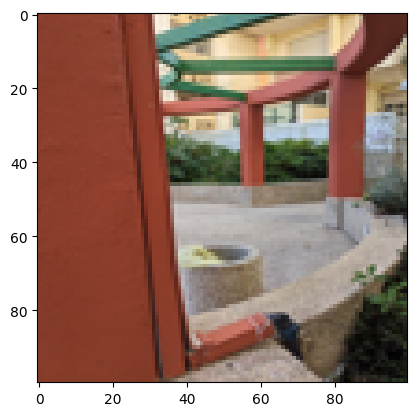

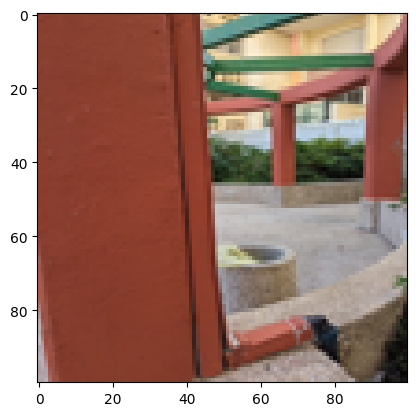

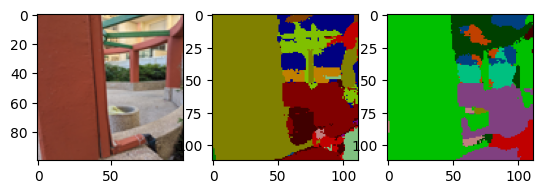

In [12]:
from PIL import Image
import torchvision.transforms as transforms
import torch
import numpy as np
from skimage.filters.rank import entropy
from skimage.morphology import disk
import numpy as np
from utils import unnorm, remove_axes
import time
#testing!!! can be ignored!!!
address1 = path + 'images/first.jpg'
check1 = Image.open(address1).resize((100,100))
plt.figure()
plt.imshow(check1)

address2 = path + 'images/second.jpg'
check2 = Image.open(address2).resize((100,100))
plt.figure()
plt.imshow(check2)
plot_segmentations(check2)

stime=time.time()
segmentation(check1)
print(movement(check1,check2,20)[0])
etime=time.time()
print(etime-stime)

**Testing!** can be ignored

0.22899556159973145


<ipython-input-13-3174338b8e0c>:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


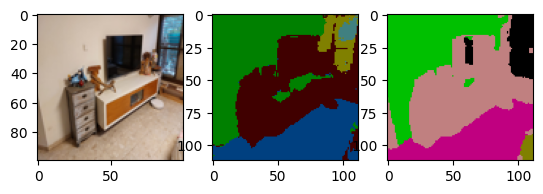

In [13]:
import time
#testing!!! can be ignored!!!
address = path + 'images/tv_stand.jpg'
img = Image.open(address).resize((100,100))

plt.figure()
plt.imshow(img)

stime = time.time()
img, img_cluster_pred, img_linear_pred = segmentation(img)#activation example
etime = time.time()
print(etime-stime)
plt.subplot(1,3,1)
plt.imshow(img)
plt.subplot(1,3,2)
plt.imshow(img_cluster_pred)
plt.subplot(1,3,3)
plt.imshow(img_linear_pred)


**Testing!** can be ignored

<class 'PIL.Image.Image'>
0.23643112182617188
0.04948902130126953


<ipython-input-14-fb953106a9d9>:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


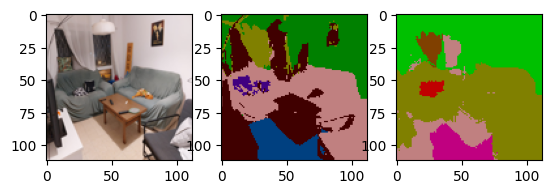

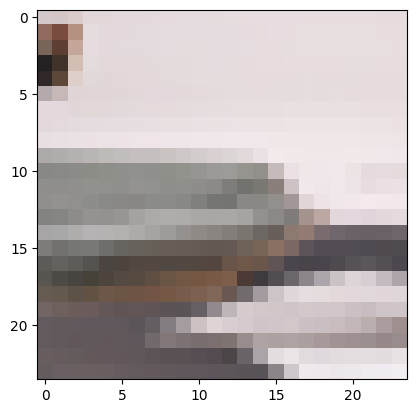

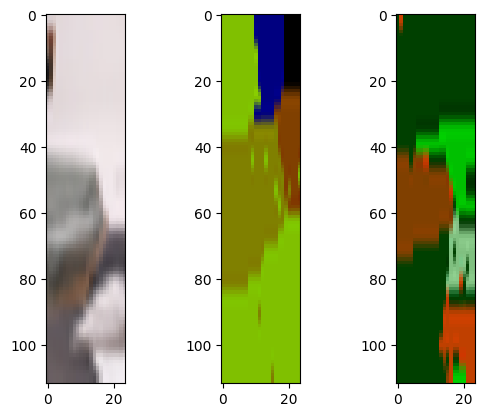

In [14]:
import numpy as np
from PIL import Image
#testing!!! can be ignored!!!

address = path + 'images/Beer_sheva_livingroom.jpg'
img = Image.open(address).resize((112,112))
print(type(img))

plt.figure()
plt.imshow(img)

stime = time.time()
img, img_cluster_pred, img_linear_pred = segmentation(img)#activation example
etime = time.time()
print(etime-stime)
plt.subplot(1,3,1)
plt.imshow(img)
plt.subplot(1,3,2)
plt.imshow(img_cluster_pred)
plt.subplot(1,3,3)
plt.imshow(img_linear_pred)

img = Image.open(address).resize((112,112)).crop((112-24,0,112,112)).resize((24,24))

plt.figure()
plt.imshow(img)

stime = time.time()
img, img_cluster_pred, img_linear_pred = segmentation(img,24)#activation example
etime = time.time()
print(etime-stime)
plt.figure()
plt.subplot(1,3,1)
plt.imshow(img.resize((24,112)))#how to stech it back to (112,24)
plt.subplot(1,3,2)
plt.imshow(img_cluster_pred.resize((24,112)))
plt.subplot(1,3,3)
plt.imshow(img_linear_pred.resize((24,112)))




**two function that create the segmentation of the next frame based on the segmentation of one image, and the correlation between the two frames**

In [15]:
#a function that segments a frame either by STEGO alone, or by using a prior
#segmented frame and passing only parts of the new frame thorugh the STEGO module
def next_seg_with_surface_conditions(img1, img2, img1_seg, is_first=True, patch=None, location=None):
    #calculate the movement between the frames
    vec, patch, max_val = movement(img1, img2, patch=patch, location=location)
    #define the similarity threshold (cross correlation)
    threshold = 0.999

    size = img1.size
    img1 = np.array(img1)
    height, width = img1.shape[0], img1.shape[1]
    x = -vec[0]
    y = -vec[1]
    #define a minumum image size to pass thorugh STEGO once we find a match
    min_size=24*4
    if y>=0:
      ynew = min_size
    else:
      ynew = -min_size
    if x>=0:
      xnew = min_size
    else:
      xnew = -min_size

    #check if we found a match between the frames and the movement calculation is valid.
    #we do two checks, the first is to check if the movement is larger then 20% if this is
    #the case, we either found a wrong patch, or movemnt was too quick.
    #second check is to see if the cross correlation is good enough (similar enough)
    if abs(x) > 0.2 * size[1] or abs(y) > 0.2 * size[0]:
        _, _, seg = segmentation(img2, resolution_def, False, True)
        return [seg, False, patch]
    if max_val <threshold:
      _, _, seg = segmentation(img2, resolution_def, False, True)
      return [seg, False, patch]

    rec1 = np.array(img2)
    rec2 = np.array(img2)

    #define the regions that require segmentation
    if abs(y)<min_size:
      if y >= 0:
        rec1 = rec1[:, -1-ynew-1:-1, :]
      else:
        rec1 = rec1[:, 0:abs(ynew)+1, :]
    else:
      if y >= 0:
        rec1 = rec1[:, -1-y-1:-1, :]
      else:
        rec1 = rec1[:, 0:abs(y)+1, :]

    if abs(x)<min_size:
      if x >= 0:
        rec2 = rec2[-1-xnew-1:, :, :]
      else:
        rec2 = rec2[0:abs(xnew)+1, :, :]
    else:
      if x >= 0:
        rec2 = rec2[-1-x-1:, :, :]
      else:
        rec2 = rec2[0:abs(x)+1, :, :]

    if y >= 0:
        rec2 = rec2[:, :width-y+1, :]
    else:
        rec2 = rec2[:, abs(y):, :]

    rec1height, rec1width = rec1.shape[0], rec1.shape[1]
    rec2height, rec2width = rec2.shape[0], rec2.shape[1]


    rec1 = Image.fromarray(rec1.astype(np.uint8))
    rec2 = Image.fromarray(rec2.astype(np.uint8))

    #pass the new regions thorugh STEGO module
    samll_resoluiton = max(int(resolution_def/4),56)
    #_, _, rec1_seg = segmentation(rec1, samll_resoluiton, False, True)
    #_, _, rec2_seg = segmentation(rec2, samll_resoluiton, False, True)
    _, _, rec1_seg = segmentation(rec1, samll_resoluiton, False, True)
    _, _, rec2_seg = segmentation(rec2, samll_resoluiton, False, True)

    rec1_seg = rec1_seg.resize((rec1width, rec1height))
    rec2_seg = rec2_seg.resize((rec2width, rec2height))


    img1_seg = np.array(img1_seg)
    rec2_seg = np.array(rec2_seg)
    rec1_seg = np.array(rec1_seg)

    if y >= 0:
      rec1_seg = rec1_seg[:, -1-y-1:-1, :]
    else:
      rec1_seg = rec1_seg[:, 0:abs(y)+1, :]
    if x >= 0:
      rec2_seg = rec2_seg[-1-x-1:, :, :]
    else:
      rec2_seg = rec2_seg[0:abs(x)+1, :, :]

    rec1height, rec1width = rec1_seg.shape[0], rec1_seg.shape[1]
    rec2height, rec2width = rec2_seg.shape[0], rec2_seg.shape[1]

    #match the segmentation classes incase of false classification
    if y>=0:
      if x>=0:
        red = rec1_seg[:,:,0]
        green = rec1_seg[:,:,1]
        blue = rec1_seg[:,:,2]
        for i in range(rec1height-x):
          r = rec1_seg[i,0,0]
          g = rec1_seg[i,0,1]
          b = rec1_seg[i,0,2]
          r_n = img1_seg[x+i,-1,0]
          g_n = img1_seg[x+i,-1,1]
          b_n = img1_seg[x+i,-1,2]
          red[red == r]=r_n
          green[green == g]=g_n
          blue[blue == b]=b_n
        rec1_seg[:,:,0] = red
        rec1_seg[:,:,1] = green
        rec1_seg[:,:,2] = blue
      if x<0:
        red = rec1_seg[:,:,0]
        green = rec1_seg[:,:,1]
        blue = rec1_seg[:,:,2]
        for i in range(rec1height-abs(x)):
          r = rec1_seg[abs(x)+i,0,0]
          g = rec1_seg[abs(x)+i,0,1]
          b = rec1_seg[abs(x)+i,0,2]
          r_n = img1_seg[i,-1,0]
          g_n = img1_seg[i,-1,1]
          b_n = img1_seg[i,-1,2]
          red[red == r]=r_n
          green[green == g]=g_n
          blue[blue == b]=b_n
        rec1_seg[:,:,0] = red
        rec1_seg[:,:,1] = green
        rec1_seg[:,:,2] = blue

    if y<0:
      if x>=0:
        red = rec1_seg[:,:,0]
        green = rec1_seg[:,:,1]
        blue = rec1_seg[:,:,2]
        for i in range(rec1height-x):
          r = rec1_seg[i,-1,0]
          g = rec1_seg[i,-1,1]
          b = rec1_seg[i,-1,2]
          r_n = img1_seg[x+i,0,0]
          g_n = img1_seg[x+i,0,1]
          b_n = img1_seg[x+i,0,2]
          red[red == r]=r_n
          green[green == g]=g_n
          blue[blue == b]=b_n
        rec1_seg[:,:,0] = red
        rec1_seg[:,:,1] = green
        rec1_seg[:,:,2] = blue
      if x<0:
        red = rec1_seg[:,:,0]
        green = rec1_seg[:,:,1]
        blue = rec1_seg[:,:,2]
        for i in range(rec1height-abs(x)):
          r = rec1_seg[abs(x)+i,-1,0]
          g = rec1_seg[abs(x)+i,-1,1]
          b = rec1_seg[abs(x)+i,-1,2]
          r_n = img1_seg[i,0,0]
          g_n = img1_seg[i,0,1]
          b_n = img1_seg[i,0,2]
          red[red == r]=r_n
          green[green == g]=g_n
          blue[blue == b]=b_n
        rec1_seg[:,:,0] = red
        rec1_seg[:,:,1] = green
        rec1_seg[:,:,2] = blue

    if x>0:
      if y>=0:
        red = rec2_seg[:,:,0]
        green = rec2_seg[:,:,1]
        blue = rec2_seg[:,:,2]
        for i in range(width-y):
          r = rec2_seg[-1-x,i,0]
          g = rec2_seg[-1-x,i,1]
          b = rec2_seg[-1-x,i,2]
          r_n = img1_seg[-1,y+i,0]
          g_n = img1_seg[-1,y+i,1]
          b_n = img1_seg[-1,y+i,2]
          red[red == r]=r_n
          green[green == g]=g_n
          blue[blue == b]=b_n
        rec2_seg[:,:,0] = red
        rec2_seg[:,:,1] = green
        rec2_seg[:,:,2] = blue
      if y<0:
        red = rec2_seg[:,:,0]
        green = rec2_seg[:,:,1]
        blue = rec2_seg[:,:,2]
        for i in range(width-abs(y)):
          r = rec2_seg[-1-x,i,0]
          g = rec2_seg[-1-x,i,1]
          b = rec2_seg[-1-x,i,2]
          r_n = img1_seg[-1,i,0]
          g_n = img1_seg[-1,i,1]
          b_n = img1_seg[-1,i,2]
          red[red == r]=r_n
          green[green == g]=g_n
          blue[blue == b]=b_n
        rec2_seg[:,:,0] = red
        rec2_seg[:,:,1] = green
        rec2_seg[:,:,2] = blue
    if x<0:
      if y>=0:
        red = rec2_seg[:,:,0]
        green = rec2_seg[:,:,1]
        blue = rec2_seg[:,:,2]
        for i in range(width-y):
          r = rec2_seg[abs(x),i,0]
          g = rec2_seg[abs(x),i,1]
          b = rec2_seg[abs(x),i,2]
          r_n = img1_seg[0,y+i,0]
          g_n = img1_seg[0,y+i,1]
          b_n = img1_seg[0,y+i,2]
          red[red == r]=r_n
          green[green == g]=g_n
          blue[blue == b]=b_n
        rec2_seg[:,:,0] = red
        rec2_seg[:,:,1] = green
        rec2_seg[:,:,2] = blue
      if y<0:
        red = rec2_seg[:,:,0]
        green = rec2_seg[:,:,1]
        blue = rec2_seg[:,:,2]
        for i in range(rec2width):
          r = rec2_seg[abs(x),i,0]
          g = rec2_seg[abs(x),i,1]
          b = rec2_seg[abs(x),i,2]
          r_n = img1_seg[0,i,0]
          g_n = img1_seg[0,i,1]
          b_n = img1_seg[0,i,2]
          red[red == r]=r_n
          green[green == g]=g_n
          blue[blue == b]=b_n
        rec2_seg[:,:,0] = red
        rec2_seg[:,:,1] = green
        rec2_seg[:,:,2] = blue

        if y>=0:
          if x>=0:
            red = rec1_seg[:,:,0]
            green = rec1_seg[:,:,1]
            blue = rec1_seg[:,:,2]
            for i in range(x):
              r = rec1_seg[-x+i,0,0]
              g = rec1_seg[-x+i,0,1]
              b = rec1_seg[-x+i,0,2]
              r_n = rec2_seg[i+1,-1,0]
              g_n = rec2_seg[i+1,-1,1]
              b_n = rec2_seg[i+1,-1,2]
              red[red == r]=r_n
              green[green == g]=g_n
              blue[blue == b]=b_n
            rec1_seg[:,:,0] = red
            rec1_seg[:,:,1] = green
            rec1_seg[:,:,2] = blue
          if x<0:
            red = rec1_seg[:,:,0]
            green = rec1_seg[:,:,1]
            blue = rec1_seg[:,:,2]
            for i in range(abs(x)):
              r = rec1_seg[i,0,0]
              g = rec1_seg[i,0,1]
              b = rec1_seg[i,0,2]
              r_n = rec2_seg[i,-1,0]
              g_n = rec2_seg[i,-1,1]
              b_n = rec2_seg[i,-1,2]
              red[red == r]=r_n
              green[green == g]=g_n
              blue[blue == b]=b_n
            rec1_seg[:,:,0] = red
            rec1_seg[:,:,1] = green
            rec1_seg[:,:,2] = blue
        if y<0:
          if x>=0:
            red = rec1_seg[:,:,0]
            green = rec1_seg[:,:,1]
            blue = rec1_seg[:,:,2]
            for i in range(x):
              r = rec1_seg[-x+i,-1,0]
              g = rec1_seg[-x+i,-1,1]
              b = rec1_seg[-x+i,-1,2]
              r_n = rec2_seg[i,0,0]
              g_n = rec2_seg[i,0,1]
              b_n = rec2_seg[i,0,2]
              red[red == r]=r_n
              green[green == g]=g_n
              blue[blue == b] = b_n
            rec1_seg[:,:,0] = red
            rec1_seg[:,:,1] = green
            rec1_seg[:,:,2] = blue
          if x<0:
            red = rec1_seg[:,:,0]
            green = rec1_seg[:,:,1]
            blue = rec1_seg[:,:,2]
            for i in range(abs(x)):
              r = rec1_seg[i,-1,0]
              g = rec1_seg[i,-1,1]
              b = rec1_seg[i,-1,2]
              r_n = rec2_seg[i,0,0]
              g_n = rec2_seg[i,0,1]
              b_n = rec2_seg[i,0,2]
              red[red == r]=r_n
              green[green == g]=g_n
              blue[blue == b]=b_n
            rec1_seg[:,:,0] = red
            rec1_seg[:,:,1] = green
            rec1_seg[:,:,2] = blue


    # paste the new regions to the new image
    img2 = np.array(img2)
    if y >= 0:
        img2[:, -1-y:, :] = rec1_seg
    else:
        img2[:, 0:abs(y)+1, :] = rec1_seg

    if x >= 0:
        if y >= 0:
            img2[-1-x-1:, :width-abs(y)+1, :] = rec2_seg
        else:
            img2[-1-x-1:, abs(y):, :] = rec2_seg
    else:
        if y >= 0:
            img2[:abs(x)+1, 0:width-y+1, :] = rec2_seg
        else:
            img2[:abs(x)+1, abs(y):, :] = rec2_seg

    #paste the old segmentation image into the new image with the corresponding with the movement
    if y >= 0:
        if x >= 0:
            img2[:height-x, 0:width-y, :] = img1_seg[x:, y:, :]
        else:
            img2[abs(x):, :width-y, :] = img1_seg[:height-abs(x), y:, :]
    else:
        if x >= 0:
            img2[:height-x, abs(y):, :] = img1_seg[x:, :width-abs(y), :]
        else:
            img2[abs(x):, abs(y):, :] = img1_seg[:height-abs(x), :width-abs(y), :]


    img2 = Image.fromarray(img2.astype(np.uint8))
    #return the aproximated segmentated image, True for managing to approximate, and the patch
    return [img2, True, patch]


In [16]:
#a function that segments a frame either by STEGO alone, or by using a prior
#segmented frame and passing only parts of the new frame thorugh the STEGO module
def next_seg_no_surface_conditions(img1, img2, img1_seg, is_first=True, patch=None, location=None):
    #calculate the movement between the frames
    vec, patch, max_val = movement(img1, img2, patch=patch, location=location)
    #define the similarity threshold (cross correlation)
    threshold = 0.999

    size = img1.size
    img1 = np.array(img1)
    height, width = img1.shape[0], img1.shape[1]
    x = -vec[0]
    y = -vec[1]
    #define a minumum image size to pass thorugh STEGO once we find a match
    min_size=24*6
    if y>=0:
      ynew = min_size
    else:
      ynew = -min_size
    if x>=0:
      xnew = min_size
    else:
      xnew = -min_size

    #check if we found a match between the frames and the movement calculation is valid.
    #we do two checks, the first is to check if the movement is larger then 20% if this is
    #the case, we either found a wrong patch, or movemnt was too quick.
    #second check is to see if the cross correlation is good enough (similar enough)
    if abs(x) > 0.2 * size[1] or abs(y) > 0.2 * size[0]:
        _, _, seg = segmentation(img2, resolution_def, False, True)
        return [seg, False, patch]
    if max_val <threshold:
      _, _, seg = segmentation(img2, resolution_def, False, True)
      return [seg, False, patch]

    rec1 = np.array(img2)
    rec2 = np.array(img2)

    #define the regions that require segmentation
    if abs(y)<min_size:
      if y >= 0:
        rec1 = rec1[:, -1-ynew-1:-1, :]
      else:
        rec1 = rec1[:, 0:abs(ynew)+1, :]
    else:
      if y >= 0:
        rec1 = rec1[:, -1-y-1:-1, :]
      else:
        rec1 = rec1[:, 0:abs(y)+1, :]

    if abs(x)<min_size:
      if x >= 0:
        rec2 = rec2[-1-xnew-1:, :, :]
      else:
        rec2 = rec2[0:abs(xnew)+1, :, :]
    else:
      if x >= 0:
        rec2 = rec2[-1-x-1:, :, :]
      else:
        rec2 = rec2[0:abs(x)+1, :, :]

    if y >= 0:
        rec2 = rec2[:, :width-y+1, :]
    else:
        rec2 = rec2[:, abs(y):, :]

    rec1height, rec1width = rec1.shape[0], rec1.shape[1]
    rec2height, rec2width = rec2.shape[0], rec2.shape[1]


    rec1 = Image.fromarray(rec1.astype(np.uint8))
    rec2 = Image.fromarray(rec2.astype(np.uint8))

    #pass the new regions thorugh STEGO module
    samll_resoluiton = max(int(resolution_def/4),56)
    #_, _, rec1_seg = segmentation(rec1, samll_resoluiton, False, True)
    #_, _, rec2_seg = segmentation(rec2, samll_resoluiton, False, True)
    _, _, rec1_seg = segmentation(rec1, samll_resoluiton, False, True)
    _, _, rec2_seg = segmentation(rec2, samll_resoluiton, False, True)


    rec1_seg = rec1_seg.resize((rec1width, rec1height))
    rec2_seg = rec2_seg.resize((rec2width, rec2height))


    img1_seg = np.array(img1_seg)
    rec2_seg = np.array(rec2_seg)
    rec1_seg = np.array(rec1_seg)

    if y >= 0:
      rec1_seg = rec1_seg[:, -1-y-1:-1, :]
    else:
      rec1_seg = rec1_seg[:, 0:abs(y)+1, :]
    if x >= 0:
      rec2_seg = rec2_seg[-1-x-1:, :, :]
    else:
      rec2_seg = rec2_seg[0:abs(x)+1, :, :]

    rec1height, rec1width = rec1_seg.shape[0], rec1_seg.shape[1]
    rec2height, rec2width = rec2_seg.shape[0], rec2_seg.shape[1]

   # paste the new regions to the new image
    img2 = np.array(img2)
    if y >= 0:
        img2[:, -1-y:, :] = rec1_seg
    else:
        img2[:, 0:abs(y)+1, :] = rec1_seg

    #paste the old segmentation image into the new image with the corresponding with the movement
    if x >= 0:
        if y >= 0:
            img2[-1-x-1:, :width-abs(y)+1, :] = rec2_seg
        else:
            img2[-1-x-1:, abs(y):, :] = rec2_seg
    else:
        if y >= 0:
            img2[:abs(x)+1, 0:width-y+1, :] = rec2_seg
        else:
            img2[:abs(x)+1, abs(y):, :] = rec2_seg
    # Paste img1_seg
    if y >= 0:
        if x >= 0:
            img2[:height-x, 0:width-y, :] = img1_seg[x:, y:, :]
        else:
            img2[abs(x):, :width-y, :] = img1_seg[:height-abs(x), y:, :]
    else:
        if x >= 0:
            img2[:height-x, abs(y):, :] = img1_seg[x:, :width-abs(y), :]
        else:
            img2[abs(x):, abs(y):, :] = img1_seg[:height-abs(x), :width-abs(y), :]


    img2 = Image.fromarray(img2.astype(np.uint8))
    #return the aproximated segmentated image, True for managing to approximate, and the patch
    return [img2, True, patch]


In [17]:
#a function that segments a frame either by STEGO alone, or by using a prior
#segmented frame and passing only parts of the new frame thorugh the STEGO module
def next_seg_full_image_version(img1, img2, img1_seg, is_first=True, patch=None, location=None):
    #calculate the movement between the frames
    vec, patch, max_val = movement(img1, img2, patch=patch, location=location)
    #define the similarity threshold (cross correlation)
    threshold = 0.999

    size = img1.size
    img1 = np.array(img1)
    height, width = img1.shape[0], img1.shape[1]
    x = -vec[0]
    y = -vec[1]

    #check if we found a match between the frames and the movement calculation is valid.
    #we do two checks, the first is to check if the movement is larger then 20% if this is
    #the case, we either found a wrong patch, or movemnt was too quick.
    #second check is to see if the cross correlation is good enough (similar enough)
    if abs(x) > 0.2 * size[1] or abs(y) > 0.2 * size[0]:
        _, _, seg = segmentation(img2, resolution_def, False, True)
        return [seg, False, patch]
    if max_val <threshold:
      _, _, seg = segmentation(img2, resolution_def, False, True)
      return [seg, False, patch]

    img2 = np.array(img2)
    img2 = Image.fromarray(img2.astype(np.uint8))
    #pass the new image thorugh STEGO module
    samll_resoluiton = max(int(resolution_def/4),56)
    _, _, img2_seg = segmentation(img2, samll_resoluiton, False, True)

    img2_seg=img2_seg.resize((resolution_def,resolution_def))


    img1_seg = np.array(img1_seg)
    img2_seg = np.array(img2_seg)

    # Paste img1_seg onto the low resolution segmentation of img2
    if y >= 0:
        if x >= 0:
            img2_seg[:height-x, 0:width-y, :] = img1_seg[x:, y:, :]
        else:
            img2_seg[abs(x):, :width-y, :] = img1_seg[:height-abs(x), y:, :]
    else:
        if x >= 0:
            img2_seg[:height-x, abs(y):, :] = img1_seg[x:, :width-abs(y), :]
        else:
            img2_seg[abs(x):, abs(y):, :] = img1_seg[:height-abs(x), :width-abs(y), :]


    img2_seg = Image.fromarray(img2_seg.astype(np.uint8))
    #return the aproximated segmentated image, True for managing to approximate, and the patch
    return [img2_seg, True, patch]


**lower resolution by gaussian blur function**

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#a function to lower resolution and apply a gaussian blur
def gauss_blur(image, kernel_size=3,resolution=112):
  image2 = cv2.resize(image, (resolution,resolution), interpolation=cv2.INTER_LINEAR)
  blurred_image = cv2.GaussianBlur(image2, (kernel_size, kernel_size), 0)
  return blurred_image

In [19]:
#function to convert numpy img to PIL
def convertNp2Pil(img_np):
  return Image.fromarray(img_np)

# *Example  of using two diffrent segmentation VS using one and our algorithm to infer the second image*

<ipython-input-9-df0571ebe08b>:24: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  entropies = entropy(small_img, disk(patch_size))


True


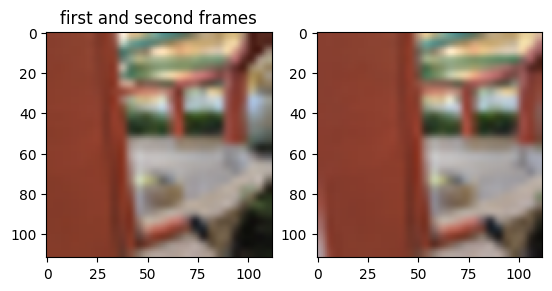

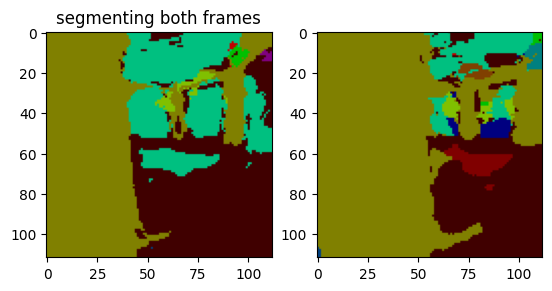

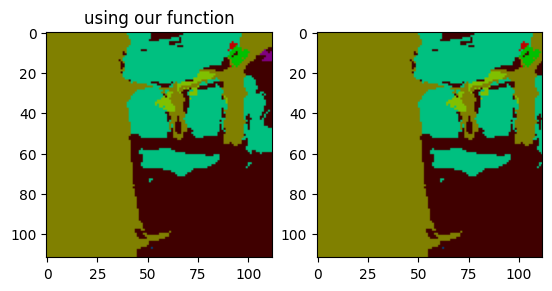

In [20]:
address1 = path + 'images/first.jpg'
address2 = path + 'images/second.jpg'

first = Image.open(address1).resize((28,28)).resize((112,112))
second = Image.open(address2).resize((28,28)).resize((112,112))

_,img1_seg,_ = segmentation(first,112,True,False)
pic,did_find,patch = next_seg_with_surface_conditions(first,second,img1_seg)
print(did_find)

_,stam,_ = segmentation(second,112,True,False)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(first)
plt.title("first and second frames")
plt.subplot(1,2,2)
plt.imshow(second)


plt.figure()
plt.subplot(1,2,1)
plt.imshow(img1_seg)
plt.title("segmenting both frames")
plt.subplot(1,2,2)
plt.imshow(stam)


plt.figure()
plt.subplot(1,2,1)
plt.imshow(img1_seg)
plt.title("using our function")
plt.subplot(1,2,2)
plt.imshow(pic)

# *Our algorithm- this encompasses all the functions prior to it to segment an entire video*

In [21]:
import cv2
import numpy as np
import time

#define the working resolution
resolution_def = 112*6

#define the output path
output_path = path + ...

#insert the FPS of the fillmed video
fps = 30

#unused!! keep as 1
sample_ratio = 1
fps2=fps/sample_ratio

# Define the codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_path, fourcc, fps2, (resolution_def, resolution_def))

# Load the video file
video_path =  path + ...

# Open video capture
cap = cv2.VideoCapture(video_path)
count = 0
success_rate = 0
# Check if video opened successfully
if not cap.isOpened():
  print("Error: Could not open video.")


else:
  counter = 0
  local_count=0
  #note the stating time to messure exeqution time
  stime = time.time()
  while True:
    # Capture frame-by-frame
    for i in range(sample_ratio):#happens once
      ret, frame = cap.read()

    # If the frame was not grabbed, then we have reached the end of the video
    if not ret:
        break
    #lower the resolution of the frame
    frame = gauss_blur(frame,3,resolution_def)
    frame = convertNp2Pil(frame)

    #make sure to restart the sequence atleast once every 10 frames
    if local_count%10 == 0:
      local_count = 0
      prev_frame = frame
      #segment the current frame
      _,_,prev_frame_seg = segmentation(prev_frame,resolution_def,False,True)
      patch = None
      #save the image to the new video
      out.write(np.array(prev_frame_seg))
      success_rate = success_rate + 1
    else:
      #approximate the new frame segmentation based on our algorithm
      frame_seg, did_find,patch = next_seg_no_surface_conditions(prev_frame,frame,prev_frame_seg, False)
      #frame_seg, did_find,patch = next_seg_with_surface_conditions(prev_frame,frame,prev_frame_seg, False)
      if did_find:
        #if we approximated, great!
        out.write(np.array(frame_seg))
        success_rate = success_rate + 1
      else:
        #if we didnt find a match, reset the local counter
        local_count=0
        prev_frame = frame
        prev_frame_seg = frame_seg
        patch = None
        out.write(np.array(prev_frame_seg))

    #out.write(np.array(prev_frame_seg))

    local_count = local_count + 1
    counter = counter + 1

  #end time messurment
  etime = time.time()
  our_time=etime-stime
  print(our_time)
  # Release the video capture object
  cap.release()
# Release the video capture object
out.release()
success_rate = success_rate/counter
print(success_rate)

<ipython-input-9-df0571ebe08b>:24: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  entropies = entropy(small_img, disk(patch_size))


598.0499665737152
0.8967889908256881


# *segmenting a vido by passing each frame thorugh STEGO one by one*

In [22]:
import cv2
import numpy as np

fps = 30
sample_ratio = 1
fps2=fps/sample_ratio

output_path = path + ...
# Define the codec and create a VideoWriter object
fourcc2 = cv2.VideoWriter_fourcc(*'XVID')
out2 = cv2.VideoWriter(output_path, fourcc2, fps2, (resolution_def, resolution_def))

# Load the video file
video_path =  path + ...
#video_path =  path + 'images/messy_floor/messy_floor.mp4'

# Open video capture
cap2 = cv2.VideoCapture(video_path)
count = 0
# Check if video opened successfully
if not cap2.isOpened():
  print("Error: Could not open video.")


else:
  #start time messurment
  stime = time.time()
  while True:
    # Capture frame-by-frame
    for i in range(sample_ratio):
      ret, frame = cap2.read()

    # If the frame was not grabbed, then we have reached the end of the video
    if not ret:
        break
    frame = convertNp2Pil(frame)
    frame = frame.resize((resolution_def,resolution_def))
    #pass the image thorugh STEGO
    _,_,frame_seg = segmentation(frame,resolution_def,False,True)
    #save the image
    out2.write(np.array(frame_seg))
  #end time messurment
  etime = time.time()
  stego_time=etime-stime
  print(stego_time)
  # Release the video capture object
  cap2.release()
# Release the video capture object
out2.release()

2424.6791672706604


In [24]:
import cv2
import numpy as np

def combine_videos(video_path1, video_path2, video_path3, output_path):
    # Open the video files
    cap4 = cv2.VideoCapture(video_path1)
    cap5 = cv2.VideoCapture(video_path2)
    cap6 = cv2.VideoCapture(video_path3)

    # Check if the videos were opened successfully
    if not cap4.isOpened() or not cap5.isOpened() or not cap6.isOpened():
        print("Error opening video streams or files")

    # Get video properties
    fps = cap5.get(cv2.CAP_PROP_FPS)
    width = int(cap5.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap5.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_count = int(cap5.get(cv2.CAP_PROP_FRAME_COUNT))

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width * 3, height))

    for _ in range(frame_count):
        ret1, frame1 = cap4.read()
        ret2, frame2 = cap5.read()
        ret3, frame3 = cap6.read()

        if not ret1 or not ret2 or not ret3:
            break

        frame1 = gauss_blur(frame1,3,resolution_def)

        # Concatenate the frames horizontally
        combined_frame = np.hstack((frame1, frame2, frame3))

        # Write the frame into the output video
        out.write(combined_frame)

    # Release the video captures and writer
    cap4.release()
    cap5.release()
    cap6.release()
    out.release()

    print(f"Output video saved to {output_path}")

# Example usage:
combine_videos(path + ..., path + ..., path + ..., path + ...)


Output video saved to /content/drive/MyDrive/project/project_stegoV3/project_stegoV3/images/LivingRoom/combine_to_compare.mp4
